#### 本项目使用了 NVIDIA 加速推理平台，具体信息请查看 ：https://build.nvidia.com/
**请在 https://build.nvidia.com/explore/discover 注册账户，并生成自己的NVIDIA_API_KEY**

### Step 1  - 使用NVIDIA_API_KEY

In [1]:
import getpass
import os

if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

In [2]:
# 查看可以调用的模型
from langchain_nvidia_ai_endpoints import ChatNVIDIA
for model in ChatNVIDIA.get_available_models():
    print(model.id)

mistralai/mistral-7b-instruct-v0.3
deepseek-ai/deepseek-coder-6.7b-instruct
google/gemma-2b
writer/palmyra-fin-70b-32k
writer/palmyra-med-70b-32k
google/recurrentgemma-2b
mistralai/mixtral-8x22b-instruct-v0.1
microsoft/phi-3-medium-4k-instruct
databricks/dbrx-instruct
snowflake/arctic
aisingapore/sea-lion-7b-instruct
google/codegemma-7b
ibm/granite-8b-code-instruct
meta/llama3-70b-instruct
meta/llama2-70b
google/gemma-2-9b-it
nvidia/usdcode-llama3-70b-instruct
google/paligemma
nvidia/llama3-chatqa-1.5-70b
google/deplot
microsoft/phi-3-medium-128k-instruct
adept/fuyu-8b
nvidia/llama3-chatqa-1.5-8b
mediatek/breeze-7b-instruct
microsoft/phi-3-small-128k-instruct
google/codegemma-1.1-7b
liuhaotian/llava-v1.6-34b
microsoft/kosmos-2
mistralai/mixtral-8x7b-instruct-v0.1
microsoft/phi-3-mini-4k-instruct
meta/llama-3.1-8b-instruct
microsoft/phi-3-mini-128k-instruct
ibm/granite-34b-code-instruct
mistralai/mamba-codestral-7b-v0.1
nvidia/neva-22b
meta/codellama-70b
writer/palmyra-med-70b
seallms/s

### Step 2 - 初始化SLM
**这里我们使用 phi-3-small-128k-instruct 轻量小模型** 

In [13]:
llm = ChatNVIDIA(model="microsoft/phi-3-small-128k-instruct", nvidia_api_key=nvapi_key, max_tokens=512)
result = llm.invoke("请介绍一下陈若琳教练")
print(result.content)

陈若琳教练是一位著名的中国足球教练，曾经担任过多家中国足球超级联赛球队的主教练。她在足球领域拥有丰富的经验，曾经带领过球队获得过国内外的赛事冠军。陈若琳教练以其坚定的教练风格和对球员的深刻理解而闻名，她非常注重球员的技术和心理素质的发展。除了足球，陈若琳教练还致力于提升女子足球运动，她的工作不仅仅是在场上的指导，更是为了推动女子足球在全球范围内的发展。


*直接调用 microsoft/phi-3-small-128k-instruct 模型，大模型会出现幻觉。*

In [ ]:
"""
ChatNVIDIA 的参数：
    - model (str): 用于聊天的模型。例如 "meta/llama2-70b"。
    - nvidia_api_key (str): 用于连接到托管 NIM 的 API 密钥。
    - api_key (str): 替代 nvidia_api_key 的选项。
    - base_url (str): 要连接的 NIM 的基地址。格式为 http://host:port。
    - temperature (float): 采样温度，在 [0, 1] 范围内。较高的值会导致生成的文本更具随机性。
    - max_tokens (int): 最大生成的令牌数量。
    - top_p (float): 用于分布采样的 top-p 值。
    - seed (int): 用于确定性结果的种子值。
    - stop (list[str]): 一个包含停止词的列表，当生成的文本中包含这些词时，生成过程将停止。
"""

## RAG的工作流程
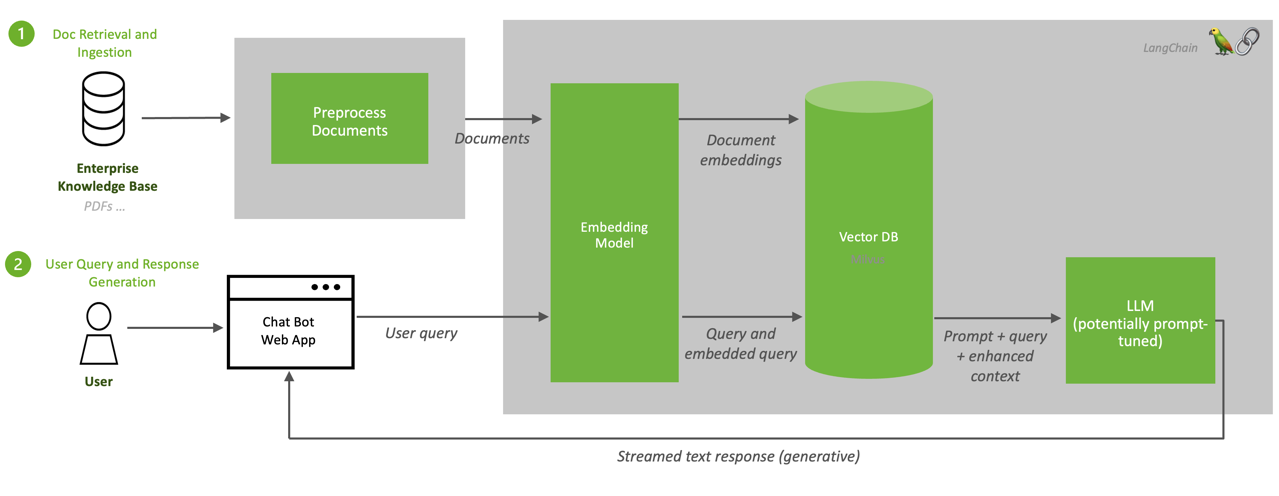

### Step 3 - 初始化NV-Embed-QA向量模型

In [4]:
# 导入向量化模型
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="NV-Embed-QA")

In [ ]:
"""
NVIDIAEmbeddings:
    - model (str): 用于嵌入的模型名称。
    - nvidia_api_key (str): 用于连接到托管 NIM 的 API 密钥。
    - api_key (str): 替代 nvidia_api_key 的选项。
    - base_url (str): 要连接的 NIM 的基地址。格式为 http://host:port。
    - truncate (str): "NONE", "START", "END", 如果输入文本超过模型的最大上下文长度，则截断输入文本。
                      默认值是 "NONE"，在这种情况下，如果输入过长会抛出错误。
    - max_batch_size (int): 批处理的最大大小，默认为 50。
"""

### Step 4 - 获取文本数据集

In [17]:
import os
from tqdm import tqdm
from pathlib import Path

# 读取私有文档（txt格式），并准备向量化存储
ps = os.listdir("./zh_data/")
data = []
sources = []
for p in ps:
    if p.endswith('.txt'):
        path2file="./zh_data/"+p
        with open(path2file,encoding="utf-8") as f:
            lines=f.readlines()
            for line in lines:
                if len(line)>=1:
                    data.append(line)
                    sources.append(path2file)

### Step 5 - 进行一些基本的清理并删除空行

In [18]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0]

(1,
 1,
 '陈若琳，1992年12月12日出生，江苏南通人，国际级运动健将 [42]，中国前女子跳水运动员、中国国家跳水队教练，主管全红婵。 2006年，她以14岁之龄出战跳水世界杯，旋即与贾童合作赢得女子双人10米跳台金牌，首度登上世界冠军宝座。两年后的北京奥运会，她又成功包揽10米跳台单人及双人项目两枚金牌。更曾获选国际泳联2010年度最佳女子跳水运动员；而她与搭档王鑫、汪皓更是合作无间，在各大小赛事的双人项目中难逢敌手。 2011年，陈若琳在世界游泳锦标赛中首度包揽10米跳台单人及双人项目的金牌，成为首位在奥运会、世界游泳锦标赛及跳水世界杯的女子10米跳台单人和双人项目中全部夺冠，成功实现“大满贯”的跳水选手，金牌数目更超越师姐伏明霞，成为“梦之队”女子跳台的新王者。2012年，陈若琳在伦敦奥运会成功卫冕10米跳台单人及双人项目，以四面金牌与名将伏明霞、郭晶晶和吴敏霞并列中国跳水队金牌榜榜首，更成为中国代表团在奥运史上的第200枚金牌得主。2016年里约奥运会跳水女子双人10米台决赛中，陈若琳与刘蕙瑕以354分夺得冠军。 2016年10月19日，陈若琳因伤通过社交平台宣布退役 [1]。2021年底，陈若琳成为全红婵的主管教练。')

### Step 6a - 将文档处理到 faiss vectorstore 并将其保存到磁盘

In [7]:
# Here we create a vector store from the documents and save it to disk.
# itemgetter函数，从可迭代对象中提取元素，通常用于排序操作
from operator import itemgetter
# FAISS 向量存储的类，将文本嵌入向量存储在向量数据库中，以便进行相似性搜索
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
# faiss 是一个独立的库，用于高效地处理大规模的向量集合。
import faiss

In [19]:
# 只需要执行一次，后面可以重读已经保存的向量存储
# chunk_size 一般是200-1000，不能大于模型的tokens
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
docs = []
metadatas = []

for i, d in enumerate(documents):
    splits = text_splitter.split_text(d)
    # print(len(splits))
    docs.extend(splits)
    metadatas.extend([{"source": sources[i]}] * len(splits))

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)
store.save_local('./zh_data/nv_embedding')

### Step 6b - 重读之前处理并保存的 Faiss Vectore 存储

In [9]:
# Load the vectorestore back.
store = FAISS.load_local("./zh_data/nv_embedding", embedder,allow_dangerous_deserialization=True)

### Step 7- 提出问题并基于phi-3-small-128k-instruct模型进行RAG检索

In [20]:
retriever = store.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("请介绍一下陈若琳教练")

'陈若琳，1992年12月12日出生于江苏南通，是一名国际级运动员和中国女子跳水队教练。她曾在跳水方面取得了显著成就，包括在北京奥运会上获得10米跳台单人和双人项目两枚金牌，以及在世界游泳锦标赛上首次包揽两项项目的金牌。2016年，她宣布退役，并于2021年底成为全红婵的主管教练，继续为中国女子跳水队的发展贡献力量。'